# Coursera Capstone Project: Battle of the Neighborhoods

This notebook will be used specifically for completing the Applied Data Science capstone project in Coursera.

**Note: I used the same notebook for the entire course.**

**Note: I the magic command "%%capture" in some cells to remove the output and improve readability**

### Week 1 Assignment

In [89]:
%%capture

!pip install numpy==1.19.4
!pip install pandas
import pandas as pd
import numpy as np

In [3]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


### Week 3 Assignment (Part 1)

Installed and imported the necessary libraries.

In [98]:
%%capture

!pip install geopy
!pip install folium==0.5.0
!pip install beautifulsoup4
!pip install matplotlib
!pip install sklearn

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json # library to handle JSON files
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from IPython.display import Image # libraries for displaying images
from IPython.core.display import HTML # libraries for displaying images
from IPython.display import display
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # plotting library
import matplotlib.pyplot as plt 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

First I got the neighborhood data from wikipedia using Beautiful Soup and created a dataframe

In [7]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

soup = BeautifulSoup(str(data_html))

Then I scraped the data to obtain the Postal Code, Borough and Neighborhood.

In [25]:
content=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        content.append(cell)

df=pd.DataFrame(content)

Then I created a pandas dataframe using this data.

In [27]:
df=pd.DataFrame(content)
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

Then I saved the dataframe into a csv file.

In [29]:
df.to_csv('neighborhood-df.csv')

Then I dropped any unnecesary data like nulls and cells that contain "Not Assigned" value. Used the shape function to print the number of rows in the dataframe.

In [41]:
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)
df = df_dropna
df.shape

(103, 5)

### Week 3 Assignment (Part 2)

Using a csv provided by cocl.us I obtained the geo-coordiantes for each Postal Code.

In [37]:
coords_url = "https://cocl.us/Geospatial_data"

coords_df = pd.read_csv(coords_url)
coords_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
coords_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

Then I merged both dataframes to create a single dataframe with all the data.

In [39]:
df = pd.merge(df, coords_df, on='PostalCode')
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

### Week 3 Assignment (Part 3)

To explore the dataframe I first counted the number of neighborhoods by each different borough.

In [56]:
df_toronto = df
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto                                                  9
Downtown Toronto                                                17
Downtown TorontoStn A PO Boxes25 The Esplanade                   1
East Toronto                                                     4
East TorontoBusiness reply mail Processing Centre969 Eastern     1
East York                                                        4
East YorkEast Toronto                                            1
Etobicoke                                                       11
EtobicokeNorthwest                                               1
MississaugaCanada Post Gateway Processing Centre                 1
North York                                                      24
Queen's Park                                                     1
Scarborough                                                     17
West Toronto                                                     6
York                                                  

Then I decided to obtain the coordinates for Toronto using the mean values of every postal code. This will be used to create a Folium map.

In [59]:
boroughs = df_toronto['Borough'].unique().tolist()
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()

print("Toronto Coordinates:",lat_toronto,",",lon_toronto)

Toronto Coordinates: 43.704607733980595 , -79.39715291165048


Then I assigned each borough a random color.

In [62]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

Finally, I created a Folium map to visualize the Toronto's boroughs. Used ipython magic folium library to display the map since Jupyter Notebook was having problem visualizing it.

In [130]:
%%capture

!pip install git+https://github.com/psychemedia/ipython_magic_folium.git
%load_ext folium_magic

In [131]:
toronto_map = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=9)

markers = []
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7).add_to(toronto_map)
    info = [lat,lng,borough+","+neighborhood]
    markers.append(info)
    
%folium_map -l 43.70460773398059,-79.39715291165048 -M markers

### Week 4 Assignment (Part 1)

First, I stored my Foursquare credentials in variables.

In [92]:
%%capture

CLIENT_ID='YZ2VEXJYI1SNN4WG4PYNGGKUE223OTCES4XDL2IMXDF3MM5X'
CLIENT_SECRET='DSWPWQTCQFN4KXDMYRPQ5AFG1VR5LRSBFBZRSQATYMHWPIQL'
VERSION = 20200514

Then I created a function that sends a request to Foursquares venues endpoint using my credentials. I limited the number of venues to 100.

In [75]:
def getVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    radius = 500
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I used the function created above to obtain the nearby venues using the previously created dataframe. I hid the results with metadata to improve readability.

In [93]:
%%capture

nearby_venues = getVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Here we can see the first 5 rows of the resulting dataframe.

In [77]:
nearby_venues.tail()

Neighborhood  \
1991  Mimico NW, The Queensway West, South of Bloor,...   
1992  Mimico NW, The Queensway West, South of Bloor,...   
1993  Mimico NW, The Queensway West, South of Bloor,...   
1994  Mimico NW, The Queensway West, South of Bloor,...   
1995  Mimico NW, The Queensway West, South of Bloor,...   

      Neighborhood Latitude  Neighborhood Longitude  \
1991              43.628841              -79.520999   
1992              43.628841              -79.520999   
1993              43.628841              -79.520999   
1994              43.628841              -79.520999   
1995              43.628841              -79.520999   

                                      Venue  Venue Latitude  Venue Longitude  \
1991             Royal Canadian Legion #210       43.628855       -79.518903   
1992                Jim & Maria's No Frills       43.631152       -79.518617   
1993  Koala Tan Tanning Salon & Sunless Spa       43.631370       -79.519006   
1994                          Value Village       43.631269       -79.518238   
1995                   Kingsway Boxing Club       43.627254       -79.526684   

              Venue Category  
1991             Social Club  
1992           Grocery Store  
1993           Tanning Salon  
1994  Thrift / Vintage Store  
1995                     Gym

In [27]:
nearby_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               4   
Alderwood, Long Branch                                                  8   
Bathurst Manor, Wilson Heights, Downsview North                        19   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      23   
Berczy Park                                                            46   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           22   
CN Tower, King and Spadina, Railway Lands, Harb...                     16   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               8   
Central Bay Street                                                     62   
Christie                                                               15   
Church and Wellesley                                                   69   
Clairville, Humberwood, Woodbine Downs, West Hu...                      4   
Clarks Corners, Tam O'Shanter, Sullivan                                12   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             25   
Davisville North                                                        9   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        6   
Don Mills North                                                         5   
Don Mills South                                                        18   
Dorset Park, Wexford Heights, Scarborough Town ...                      6   
Downsview Central                                                       3   
Downsview East                                                          4   
Downsview Northwest                                                     5   
Downsview West                                                          6   
Dufferin, Dovercourt Village                                           13   
Enclave of L4W                                                         13   
Enclave of M4L                                                         17   
Enclave of M5E                                                         85   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      5   
Fairview, Henry Farm, Oriole                                           58   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                5   
Garden District, Ryerson                                              100   
Glencairn                                                               3   
Golden Mile, Clairlea, Oakridge                                         9   
Guildwood, Morningside, West Hill                                       9   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          18   
Hillcrest Village                                                       6   
Humber Summit                                                           1   
Humberlea, Emery                                                        1   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         20   
Kennedy Park, Ionview, East Birchmount Park                             6   
Kensington Market, Chinatown, Grange Park                              59   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                

In [28]:
print('There are {} uniques vanue categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 253 uniques vanue categories.


In [29]:
print("The Venue Categories are", nearby_venues['Venue Category'].unique())

The Venue Categories are ['Fast Food Restaurant' 'Park' 'Bus Stop' 'Food & Drink Shop'
 'Hockey Arena' 'Portuguese Restaurant' 'Coffee Shop' 'Pizza Place'
 'Bakery' 'Distribution Center' 'Spa' 'Restaurant' 'Historic Site'
 'Farmers Market' 'Chocolate Shop' 'Greek Restaurant'
 'Performing Arts Venue' 'Dessert Shop' 'Breakfast Spot' 'Event Space'
 'Pub' 'Café' 'Bank' 'Sandwich Place' 'Theater' 'Asian Restaurant'
 'French Restaurant' 'Beer Store' 'Art Gallery' 'Mexican Restaurant'
 'Electronics Store' 'Discount Store' 'Hotel' 'Health Food Store'
 'Wine Shop' 'Antique Shop' 'Boutique' 'Vietnamese Restaurant'
 'Clothing Store' 'Miscellaneous Shop' "Women's Store" 'Sushi Restaurant'
 'Yoga Studio' 'Burger Joint' 'Persian Restaurant' 'Diner'
 'Japanese Restaurant' 'Burrito Place' 'Salad Place' 'Bar' 'Gym'
 'College Auditorium' 'Vegetarian / Vegan Restaurant' 'Music Venue'
 'Caribbean Restaurant' 'Gastropub' 'Gym / Fitness Center' 'Pharmacy'
 'Pet Store' 'Intersection' 'Flea Market' 'Athletics

In [30]:
"Greek Restaurant" in nearby_venues['Venue Category'].unique()

True

In [31]:
# one hot encoding
to_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(1996, 254)


Neighborhoods  Adult Boutique  Afghan Restaurant  Airport  \
0         Parkwoods               0                  0        0   
1         Parkwoods               0                  0        0   
2         Parkwoods               0                  0        0   
3         Parkwoods               0                  0        0   
4  Victoria Village               0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bistro  \
0      0                0         0           0                   0       0   
1      0                0         0           0                   0       0   
2      0                0         0           0                   0       0   
3      0                0         0           0                   0       0   
4      0                0         0           0                   0       0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0              0          0         0                     0               0   
1              0          0         0                     0               0   
2              0          0         0                     0               0   
3              0          0         0                     0               0   
4              0          0         0                     0               0   

   Brewery  Bridal Shop  Bubble Tea Shop  Burger Joint  Burrito Place  \
0        0            0                0             0              0   
1        0            0                0             0              0   
2        0            0                0             0              0   
3        0            0                0             0              0 

In [32]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(100, 254)


Neighborhoods  Adult Boutique  \
0                                        Agincourt             0.0   
1                           Alderwood, Long Branch             0.0   
2  Bathurst Manor, Wilson Heights, Downsview North             0.0   
3                                  Bayview Village             0.0   
4                Bedford Park, Lawrence Manor East             0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                0.0      0.0                 0.0           0.0   
1                0.0      0.0                 0.0           0.0   
2                0.0      0.0                 0.0           0.0   
3                0.0      0.0                 0.0           0.0   
4                0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.000000   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.000000   
4             0.0              0.0               0.0             0.043478   

   Antique Shop  Aquarium  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0           0.0       0.0          0.0                  0.0               0.0   
1           0.0       0.0          0.0                  0.0               0.0   
2           0.0       0.0          0.0                  0.0               0.0   
3           0.0       0.0          0.0                  0.0               0.0   
4           0.0       0.0          0.0                  0.0               0.0   

   Athletics & Sports  Auto Garage  Auto Workshop  BBQ Joint  Baby Store  \
0                 0.0          0.0            0.0        0.0         0.0   
1                 0.0          0.0            0.0        0.0         0.0   
2                 0.0          0.0            0.0        0.0         0.0   
3                 0.0          0.0            0.0        0.0         0.0   
4                 0.0          0.0            0.0        0.0         0.0   

   Bagel Shop  Bakery      Bank  Bar  Baseball Field  Baseball Stadium  \
0         0.0     0.0  0.000000  0.0             0.0               0.0   
1         0.0     0.0  0.000000  0.0             0.0               0.0   
2         0.0     0.0  0.105263  0.0             0.0               0.0   
3         0.0     0.0  0.250000  0.0             0.0               0.0   
4         0.0     0.0  0.000000  0.0             0.0               0.0   

   Basketball Court  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Store  Belgian Restaurant  Bistro  Boat or Ferry  Bookstore  Boutique  \
0         0.0                 0.0     0.0            0.0        0.0       0.0   
1         0.0                 0.0     0.0            0.0        0.0       0.0   
2         0.0                 0.0     0.0            0.0        0.0       0.0   
3         0.0                 0.0     0.0            0.0        0.0       0.0   
4         0.0                 0.0     0.0            0.0        0.0       0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0            0.25      0.0     0.000000   
1                   0.0            0.00      0.0     0.000000   
2                   0.0            0.00      0.0     0.052632   
3                   0.0            0.00      0.0     0.000000   
4                   0.0            0.00      0.0     0.000000   

   Bubble Tea Shop  

In [33]:
ita = to_grouped[["Neighborhoods","Italian Restaurant"]]
ita.head()

Neighborhoods  Italian Restaurant
0                                        Agincourt            0.000000
1                           Alderwood, Long Branch            0.000000
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000
3                                  Bayview Village            0.000000
4                Bedford Park, Lawrence Manor East            0.086957

In [34]:
# rename column "Neighborhoods" to "Neighborhood"
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

In [35]:
# drop "Neighborhood" column from the dataframe
X = ita.drop(['Neighborhood'], axis=1)

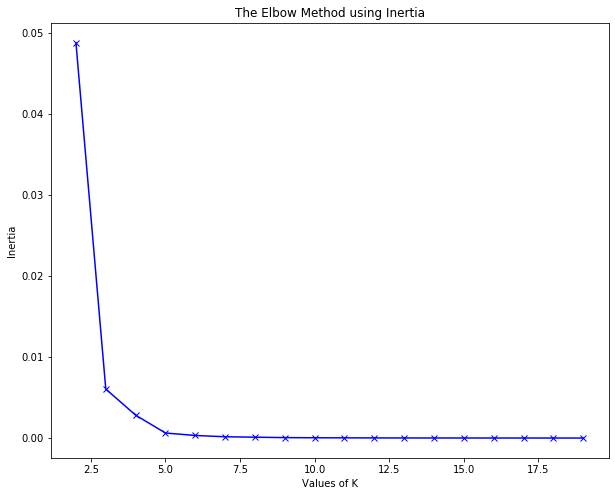

In [36]:
# find 'k' value by Elbow Method
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [37]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 3, 0, 2, 0, 0], dtype=int32)

In [38]:

# unique value in target column
np.unique(kmeans.labels_)

array([0, 1, 2, 3], dtype=int32)

In [39]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [40]:
to_merged.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.086957   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

In [41]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(nearby_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1996, 9)


Neighborhood  Italian Restaurant  Cluster Labels  \
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
1              43.602414              -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                     El Pulgarcito       43.792648       -79.259208   
0                          Twilight       43.791999       -79.258584   
0                            Mark's       43.791179       -79.259714   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   

              Venue Category  
0             Breakfast Spot  
0  Latin American Restaurant  
0                     Lounge  
0             Clothing Store  
1                Pizza Place

In [42]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(1996, 9)


Neighborhood  Italian Restaurant  \
18                                         Davisville                0.04   
18                                         Davisville                0.04   
36                           Garden District, Ryerson                0.02   
18                                         Davisville                0.04   
40  Harbourfront East, Union Station, Toronto Islands                0.02   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
18               3              43.704324              -79.388790   
18               3              43.704324              -79.388790   
36               3              43.657162              -79.378937   
18               3              43.704324              -79.388790   
40               3              43.640816              -79.381752   

                                    Venue  Venue Latitude  Venue Longitude  \
18                              Pizzaiolo       43.707301       -79.389830   
18                        Crossfit Metric       43.707480       -79.389857   
36                    Yonge-Dundas Square       43.656054       -79.380495   
18                             Second Cup       43.704344       -79.388659   
40  Pinnacle Centre Fitness Centre & Pool       43.643085       -79.377186   

   Venue Category  
18    Pizza Place  
18            Gym  
36          Plaza  
18    Coffee Shop  
40       Gym Pool

In [43]:
to_merged['Venue Category'].value_counts()['Italian Restaurant']

41

In [44]:

# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [45]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.086957   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

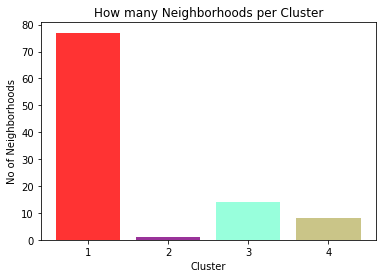

In [46]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [47]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    77
2    14
3     8
1     1
Name: Cluster Labels, dtype: int64

In [48]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

In [49]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

Borough      Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York         Parkwoods                 0.0               0   
1  North York         Parkwoods                 0.0               0   
2  North York         Parkwoods                 0.0               0   
3  North York         Parkwoods                 0.0               0   
4  North York  Victoria Village                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude            Venue  \
0              43.753259              -79.329656    Variety Store   
1              43.753259              -79.329656   TTC stop #8380   
2              43.753259              -79.329656  Brookbanks Park   
3              43.753259              -79.329656              KFC   
4              43.725882              -79.315572        Portugril   

   Venue Latitude  Venue Longitude         Venue Category  
0       43.751974       -79.333114      Food & Drink Shop  
1       43.752672       -79.326351               Bus Stop  
2       43.751976       -79.332140                   Park  
3       43.754387       -79.333021   Fast Food Restaurant  
4       43.725819       -79.312785  Portuguese Restaurant

In [50]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Borough Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York    Glencairn            0.333333               1   
1  North York    Glencairn            0.333333               1   
2  North York    Glencairn            0.333333               1   

   Neighborhood Latitude  Neighborhood Longitude                Venue  \
0              43.709577              -79.445073       Marlee Variety   
1              43.709577              -79.445073       Domino's Pizza   
2              43.709577              -79.445073  Bigabaldi's Pizzera   

   Venue Latitude  Venue Longitude      Venue Category  
0       43.709023       -79.443823   Convenience Store  
1       43.707170       -79.442658         Pizza Place  
2       43.706021       -79.442403  Italian Restaurant

In [51]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Borough     Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York  Don Mills South            0.055556               2   
1  North York  Don Mills South            0.055556               2   
2  North York  Don Mills South            0.055556               2   
3  North York  Don Mills South            0.055556               2   
4  North York  Don Mills South            0.055556               2   

   Neighborhood Latitude  Neighborhood Longitude  \
0                43.7259              -79.340923   
1                43.7259              -79.340923   
2                43.7259              -79.340923   
3                43.7259              -79.340923   
4                43.7259              -79.340923   

                           Venue  Venue Latitude  Venue Longitude  \
0              Tilley Endurables       43.727033       -79.342926   
1                 The Beer Store       43.726987       -79.341494   
2                   Swiss Chalet       43.726747       -79.341625   
3  Just Hockey Source For Sports       43.727095       -79.342591   
4             Fitness Connection       43.727473       -79.341707   

        Venue Category  
0       Clothing Store  
1           Beer Store  
2           Restaurant  
3  Sporting Goods Shop  
4                  Gym

In [52]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Borough              Neighborhood  Italian Restaurant  \
0  Downtown Toronto  Garden District, Ryerson                0.02   
1  Downtown Toronto  Garden District, Ryerson                0.02   
2  Downtown Toronto  Garden District, Ryerson                0.02   
3  Downtown Toronto  Garden District, Ryerson                0.02   
4  Downtown Toronto  Garden District, Ryerson                0.02   

   Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0               3              43.657162              -79.378937   
1               3              43.657162              -79.378937   
2               3              43.657162              -79.378937   
3               3              43.657162              -79.378937   
4               3              43.657162              -79.378937   

                         Venue  Venue Latitude  Venue Longitude  \
0  Dairy Queen / Orange Julius       43.652785       -79.380322   
1                  Tim Hortons       43.653625       -79.377732   
2                       Subway       43.654613       -79.376189   
3              Williams-Sonoma       43.653478       -79.380434   
4          lululemon athletica       43.653286       -79.380764   

         Venue Category  
0        Ice Cream Shop  
1           Coffee Shop  
2        Sandwich Place  
3  Kitchen Supply Store  
4        Clothing Store

Text(0.5, 1.0, 'Average number of Italian Restaurants per Cluster')

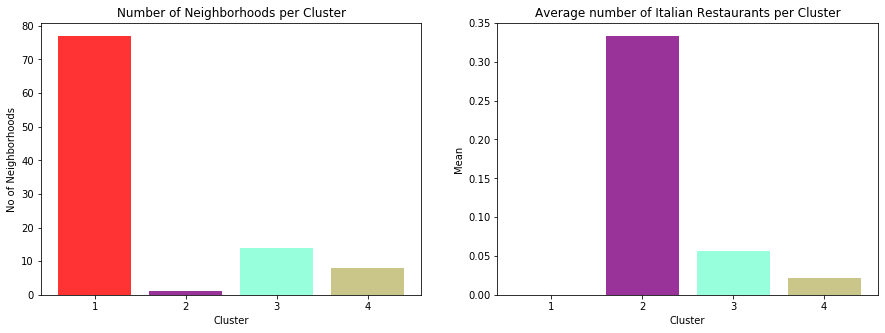

In [53]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Italian Restaurants per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean(),
                df_cluster4['Italian Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')